In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and concatenate data
df1 = pd.read_csv('data/cleaned/greater-vancouver-area-cleaned.csv')
df2 = pd.read_csv('data/cleaned/greater-toronto-area-cleaned.csv')
df = pd.concat([df1, df2], axis=0)

# Drop unnecessary columns
df.head()

,price,link,title,location,description,Nearest intersection,Bedrooms,Bathrooms,Unit type,Parking included,sqft,sqm
0,1950.0,/v-apartments-condos/delta-surrey-langley/guil...,Guildford Apartment For Rent | Mainstreet Estates,Delta/Surrey/Langley,Mainstreet Estates is professionally managed b...,150 Street / 107A Avenue,1.0,1.0,Apartment,0,625.0,58.064375
1,2245.0,/v-apartments-condos/burnaby-new-westminster/s...,Skyview Apartments - 1 Bdrm available at 908 S...,New Westminster,$500 Security Deposit Move in this month and y...,Eighth Street / Sixth Avenue,1.0,1.0,Apartment,0,595.0,55.277285
2,3400.0,/v-apartments-condos/richmond-bc/pet-friendly-...,Pet Friendly 3 beds 2 bath newly renovated hou...,Richmond,Well behaved pets welcome! Newly renovated hou...,No 1 Road / Tyson Place,3.0,1.5,House,2,1000.0,92.903000
3,3300.0,/v-apartments-condos/vancouver-downtown-west-e...,Westend Condo for Rent,Vancouver,"West of Denman reinforced concrete strata, loc...",Denman Street / Haro Street,2.0,1.0,Condo,1,780.0,72.464340
4,2499.0,/v-apartments-condos/vancouver/luxury-studio-i...,Luxury Studio in central Downtown,Vancouver,Please call 7783164156 This amazing downtown V...,Burrard Street / Comox Street,0.0,1.0,Apartment,1,500.0,46.451500


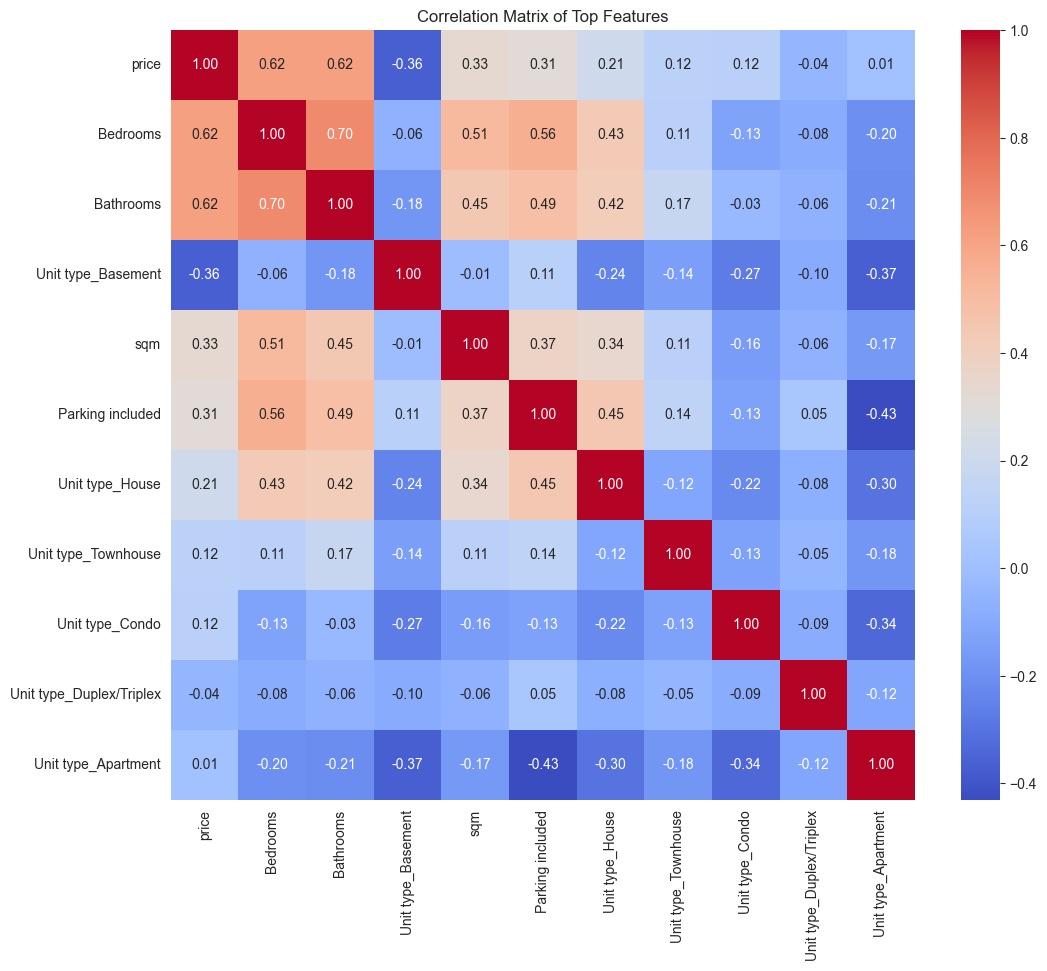

In [2]:
df.drop(columns=['sqft'], inplace=True)

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['Unit type'])

# Calculate the correlation matrix for all columns
df.drop(columns=['link','description','Nearest intersection','title', 'location'],inplace=True)

correlation_matrix = df.corr()

# Select the top N features with the highest absolute correlation with 'price'
N = 20  # You can adjust this number based on your needs
top_features = correlation_matrix['price'].abs().sort_values(ascending=False).head(N).index

# Create a correlation matrix for the top features
top_correlation_matrix = df[top_features].corr()

# Plot the heatmap for the top features
plt.figure(figsize=(12, 10))
sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top Features')
plt.show()


In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [4]:
X = df.drop(columns=['price'])
y = df['price']

# Divida os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


                        Accuracy  Precision    Recall  F1 Score
Logistic Regression     0.418654   0.628511  0.418654  0.320884
Decision Tree           0.557499   0.635426  0.557499  0.540117
Random Forest           0.561738   0.641836  0.561738  0.543275
Support Vector Machine  0.437202   0.642736  0.437202  0.348679
K-Nearest Neighbors     0.554319   0.648961  0.554319  0.536284


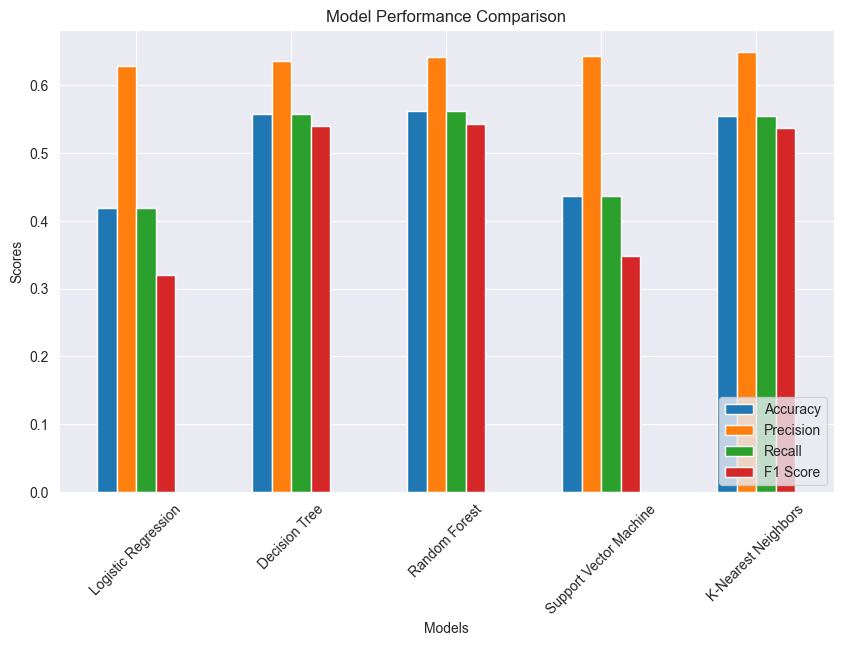

In [5]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000, solver='lbfgs'),  # Aumentando o número de iterações
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

results = {}

for model_name, model in models.items():
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Avaliar o desempenho do modelo
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    
    # Salvar os resultados
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Converter os resultados para um DataFrame para fácil visualização
results_df = pd.DataFrame(results).T
print(results_df)

# Visualização dos Resultados
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()


# Realizarei as próximas etapas utilizando o Random Forest.
### para continuar, otimizarei os hiperparametros e realizarei a validação cruzada do modelo.
 

Best parameters found by Bayesian Optimization: OrderedDict([('max_depth', 26), ('min_samples_leaf', 3), ('min_samples_split', 13), ('n_estimators', 261)])
Cross-validation scores for Bayesian Optimization: [0.44648115 0.57070052 0.98562256 0.99012993 0.47869107]
Mean cross-validation score for Bayesian Optimization: 0.6943250467533697
Best parameters found by Grid Search: {'max_depth': 21, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 311}
Cross-validation scores for Grid Search: [0.45741079 0.57016913 0.98454106 0.98874915 0.47958573]
Mean cross-validation score for Grid Search: 0.6960911736751205


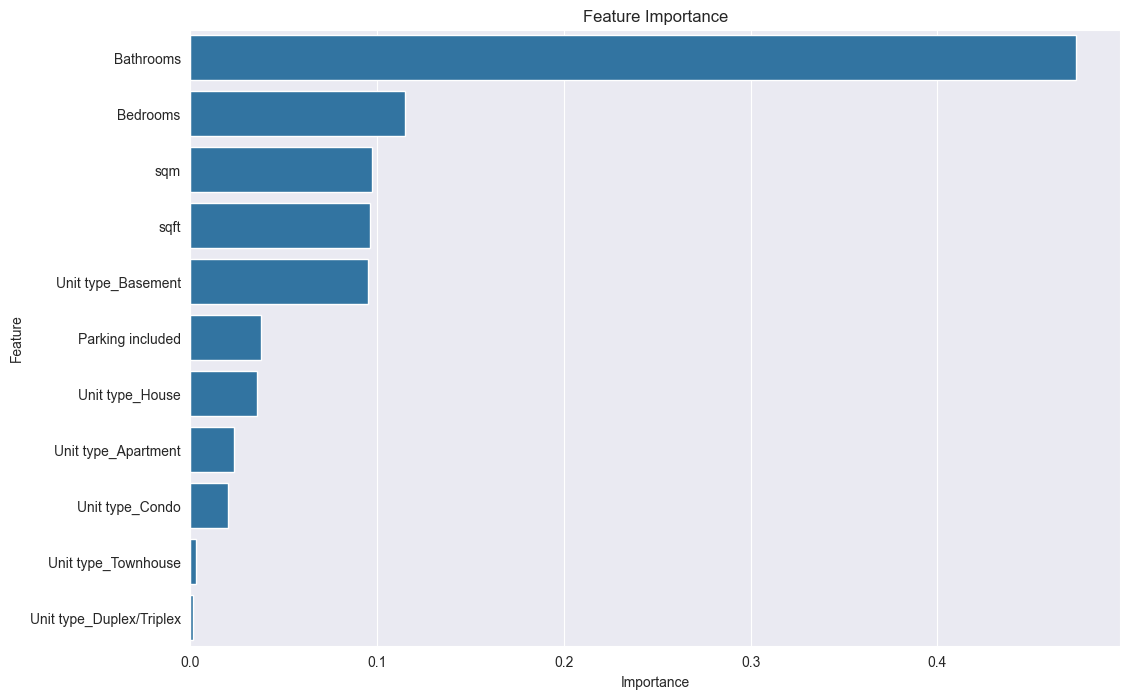

              price     Bedrooms    Bathrooms  Parking included          sqft  \
count   9432.000000  9432.000000  9432.000000       9432.000000   9432.000000   
mean    2372.623516     1.664069     1.280958          0.795802    904.708969   
std      757.847667     1.026107     0.572814          0.815157    739.704324   
min        1.000000     0.000000     1.000000          0.000000      4.000000   
25%     1850.000000     1.000000     1.000000          0.000000    573.000000   
50%     2260.000000     1.500000     1.000000          1.000000    750.000000   
75%     2795.000000     2.000000     1.000000          1.000000   1038.000000   
max    13500.000000     5.000000     6.000000          3.000000  45120.000000   

               sqm  
count  9432.000000  
mean     84.050177  
std      68.720751  
min       0.371612  
25%      53.233419  
50%      69.677250  
75%      96.433314  
max    4191.783360  


ValueError: could not convert string to float: '/v-apartments-condos/mississauga-peel-region/newly-renovated-basement-for-rent-in-brampton/1695012233'

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Integer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df1 = pd.read_csv('data/cleaned/greater-toronto-area-cleaned.csv')
df2 = pd.read_csv('data/cleaned/greater-vancouver-area-cleaned.csv')
df = pd.concat([df1, df2], axis=0)

# Example feature selection (dropping 'price' column as target)
X = df.drop(columns=['price', 'link', 'title', 'description', 'Nearest intersection', 'location'])
y = df['price']

# Encoding categorical variables if any
X = pd.get_dummies(X)

# Save the feature names before standardization
feature_names = X.columns

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
rf = RandomForestRegressor()

# Define the parameter space for Bayesian Optimization
param_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(10, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10)
}

# Perform Bayesian Optimization
bayes_search = BayesSearchCV(estimator=rf, search_spaces=param_space, cv=5, n_jobs=-1, n_iter=30, random_state=42)
bayes_search.fit(X_train, y_train)

# Best parameters from Bayesian Optimization
best_params_bayes = bayes_search.best_params_

# Using the best model from Bayesian Optimization
best_model_bayes = bayes_search.best_estimator_

# Perform cross-validation for Bayesian Optimization
cv_scores_bayes = cross_val_score(best_model_bayes, X, y, cv=5, n_jobs=-1)

print("Best parameters found by Bayesian Optimization:", best_params_bayes)
print("Cross-validation scores for Bayesian Optimization:", cv_scores_bayes)
print("Mean cross-validation score for Bayesian Optimization:", cv_scores_bayes.mean())

# Define the parameter grid for Grid Search based on the best parameters from Bayesian Optimization
param_grid = {
    'n_estimators': [best_params_bayes['n_estimators'] - 50, best_params_bayes['n_estimators'], best_params_bayes['n_estimators'] + 50],
    'max_depth': [best_params_bayes['max_depth'] - 5, best_params_bayes['max_depth'], best_params_bayes['max_depth'] + 5],
    'min_samples_split': [max(2, best_params_bayes['min_samples_split'] - 5), best_params_bayes['min_samples_split'], best_params_bayes['min_samples_split'] + 5],
    'min_samples_leaf': [max(1, best_params_bayes['min_samples_leaf'] - 2), best_params_bayes['min_samples_leaf'], best_params_bayes['min_samples_leaf'] + 2]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params_grid = grid_search.best_params_

# Using the best model from Grid Search
best_model_grid = grid_search.best_estimator_

# Perform cross-validation for Grid Search
cv_scores_grid = cross_val_score(best_model_grid, X, y, cv=5, n_jobs=-1)

print("Best parameters found by Grid Search:", best_params_grid)
print("Cross-validation scores for Grid Search:", cv_scores_grid)
print("Mean cross-validation score for Grid Search:", cv_scores_grid.mean())

# Feature importance from the best model (Grid Search)
feature_importances = best_model_grid.feature_importances_

# Verify that the lengths match
assert len(feature_importances) == len(feature_names), "Mismatch between feature_importances and feature_names lengths."

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

# Descriptive statistics
print(df.describe())

# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Scatter plot of predicted vs actual prices
y_pred = best_model_grid.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

